# Analysis of univariate random variables

### Task
1. Choose subsample with main variables for your further analysis. Then for each of
them:

2. You need to make a non-parametric estimation of PDF in form of histogram and using
kernel density function (or probability law in case of discrete RV).

3. You need to make an estimation of order statistics and represent them as “box with whiskers” plot.

4. Find one or several theoretical distributions that could describe your sample on a basis of non-parametric analysis results.

5. Estimate parameters of chosen distributions using methods of maximum likelihood and least squares method.

6. Validate your estimated parameters using QQ biplots.

7. Estimate correctness of fitted distributions using at least 2 statistical tests.

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import brazil.make_dataset

In [24]:
cols = pd.read_csv('brazil/columns_description.csv')
# cols.columns
print(cols['description'])

0                                     date (YYYY-MM-DD)
1                                          hour (HH:00)
2     Amount of precipitation in millimetres (last h...
3            Atmospheric pressure at station level (mb)
4     Maximum air pressure for the last hour in hPa ...
5     Minimum air pressure for the last hour in hPa ...
6                                 Solar radiation KJ/m2
7          Air temperature (instant) in celsius degrees
8     Dew point temperature (instant) in celsius deg...
9     Maximum temperature for the last hour in celsi...
10    Minimum temperature for the last hour in celsi...
11    Maximum dew point temperature for the last hou...
12    Minimum dew point temperature for the last hou...
13    Maximum relative humid temperature for the las...
14    Minimum relative humid temperature for the las...
15                        Relative humid in % (instant)
16             Wind direction in radius degrees (0-360)
17                       Wind gust in metres per

In [25]:
def prepare_df(df):
    abbreviation = ['date','hour','prcp', 'stp', 'smax', 'smin','gbrd','temp','dewp','tmax','tmin','dmax','dmin','hmax','hmin','hmdy','wdct', 'gust', 'wdsp', 'regi','prov','wsnm','inme','lat','lon','elvt']
    
    df.drop(['index'],inplace=True, axis=1)
    df.columns = abbreviation
    df = brazil.make_dataset.clean_na(df)
    df['date_time'] = pd.to_datetime(df['date'] + ' ' +  df['hour'])
    df.drop(['date','hour'], inplace=True, axis=1)

    return df

In [26]:
source_df = pd.read_csv("brazil/south.csv", engine='python')
source_df = prepare_df(source_df)
source_df.head(5)

,prcp,stp,smax,smin,gbrd,temp,dewp,tmax,tmin,dmax,...,gust,wdsp,regi,prov,wsnm,inme,lat,lon,elvt,date_time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,S,RS,PORTO ALEGRE,A801,-30.05,-51.166667,46.97,2000-09-22 00:00:00
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,S,RS,PORTO ALEGRE,A801,-30.05,-51.166667,46.97,2000-09-22 01:00:00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,S,RS,PORTO ALEGRE,A801,-30.05,-51.166667,46.97,2000-09-22 02:00:00
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,S,RS,PORTO ALEGRE,A801,-30.05,-51.166667,46.97,2000-09-22 03:00:00
4,0.0,1013.9,1014.2,1013.2,NaN,15.5,14.6,15.6,15.5,14.8,...,4.4,1.2,S,RS,PORTO ALEGRE,A801,-30.05,-51.166667,46.97,2000-09-22 04:00:00


Text(0.5, 1.0, 'Weather Data')

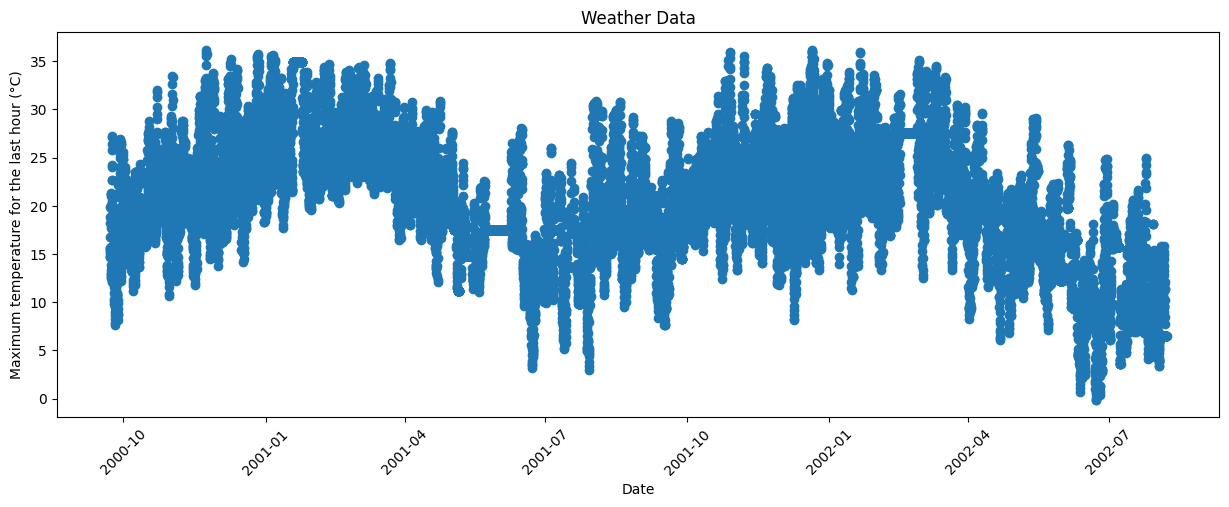

In [27]:
plt.figure(figsize=(15, 5))
plt.scatter(source_df['date_time'],source_df['tmax'])
plt.xticks(rotation=45)
plt.xlabel(u'Date')
plt.ylabel(u'Maximum temperature for the last hour (°C)')
plt.title('Weather Data')

### 2. Non-parametric estimation of PDF
**You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function (or probability law in case of discrete RV).**

A histogram aims to approximate the underlying probability density function that generated the data by binning and counting observations. Kernel density estimation (KDE) presents a different solution to the same problem. Rather than using discrete bins, a KDE plot smooths the observations with a Gaussian kernel, producing a continuous density estimate:

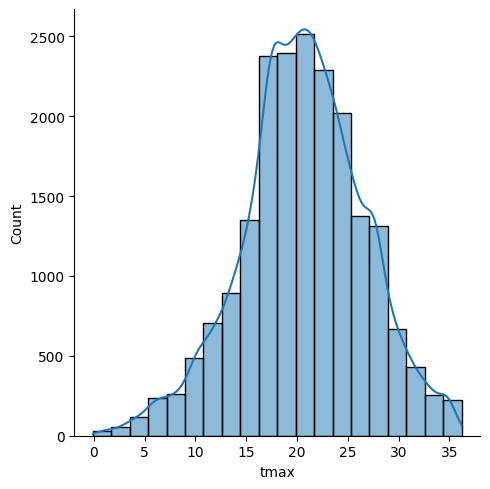

In [28]:
# plot a histogram + KDE
sns.displot(source_df, x = "tmax", kde = True, bins = 20)

### 3. Estimation of order statistics
**You need to make an estimation of order statistics and represent them as box-and-whisker plot.**

A box plot (or box-and-whisker plot) shows the distribution of quantitative data in a way that facilitates comparisons between variables or across levels of a categorical variable. The box shows the quartiles of the dataset while the whiskers extend to show the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the inter-quartile range.

In [29]:
# Get values of price at the given quantiles
quantiles = source_df.quantile(q = [.1, .25, .5, .75, .9], axis = 0, numeric_only = True).tmax
quantiles.head()

0.10    12.9
0.25    17.0
0.50    20.6
0.75    24.6
0.90    28.1
Name: tmax, dtype: float64

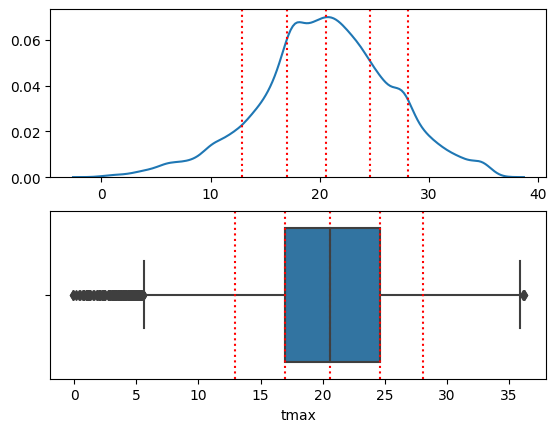

In [30]:
# Plot KDE + box-and-whisker

fig, axs = plt.subplots(nrows=2)
sns.kdeplot(source_df, x = "tmax", ax=axs[0]).set(xlabel=None, ylabel=None)
sns.boxplot(x = source_df["tmax"], ax=axs[1])

# axs[0].set_xlim([0, 2*1e6])
# axs[1].set_xlim([0, 2*1e6])

quants = quantiles.to_list()
for i in quants:
    axs[0].axvline(i, color = 'r', linestyle = ':')
    axs[1].axvline(i, color = 'r', linestyle = ':')

### 4. Theoretical Distributions Comparing
**Find one or several theoretical distributions that could describe your sample on a basis of non-parametric analysis results.**

Let's use the `distfit` python package for probability density fitting of univariate distributions.

It works by comparing the observed frequency (f) to the expected frequency from the model (f-hat), and computing the residual sum of squares (RSS). 

[distfit] >plot summary..


(<Figure size 1000x250 with 1 Axes>,
 <AxesSubplot:title={'center':'Best fit: t'}, xlabel='Distribution name', ylabel='RSS (lower is better)'>)

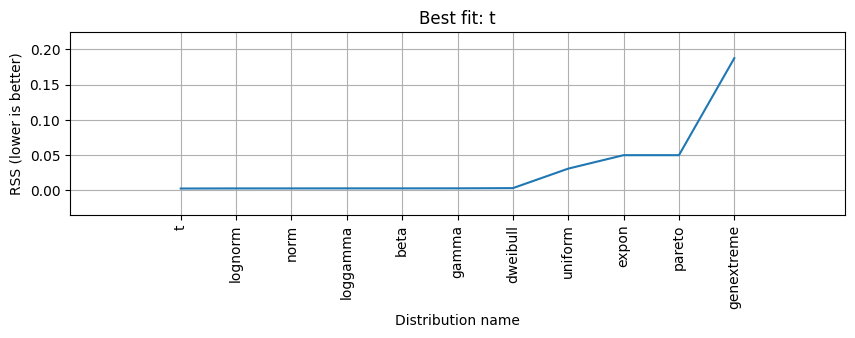

In [31]:
from distfit import distfit

analysis_df = source_df['tmax'].dropna() 
dist = distfit()
dist.fit_transform(analysis_df, verbose=0)
dist.plot_summary(figsize=(10,2.5))

As we can see from the summary, the series of distributions were fitted on the empirical data and for each a RSS was determined. The distribution with the best fit (lowest RSS) is the best fitting distribution.

Now we can plot two theoretical distributions with the lowest RSS:

[distfit] >plot..
[distfit] >plot..


(None,
 <AxesSubplot:title={'center':'\ndweibull\nRSS(c=1.21627, loc=20.5513, scale=5.01956)'}, xlabel='Values', ylabel='Frequency'>)

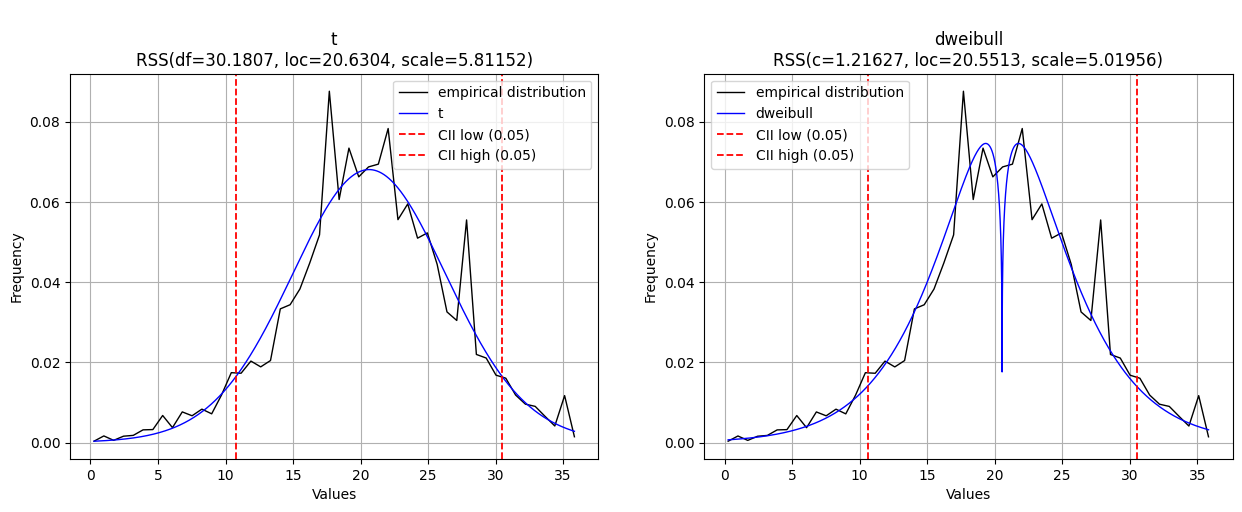

In [32]:
fig, ax = plt.subplots(figsize=(15, 5), ncols=2)

# Student's t-distribution
dist = distfit(distr='t')
dist.fit_transform(analysis_df, verbose=0)
dist.plot(ax = ax[0])

# Double Weibull distribution
dist = distfit(distr='dweibull')
dist.fit_transform(analysis_df, verbose=0)
dist.plot(ax = ax[1])

### 5. QQ biplots parameters estimation

1. Estimate parameters of chosen distributions using methods of maximum likelihood and least squares method.

2. Validate your estimated parameters using QQ plots.

3. Estimate correctness of fitted distributions using at least 2 statistical tests.**

`Student's t-distribution`

In [33]:
# The distribution parameters are determined using the fit function based on the maximum likelihood estimation
params_1 = scipy.stats.t.fit(analysis_df) # MLE is the default method
pdf = scipy.stats.t.pdf(analysis_df, *params_1)

# Calculation of the Kolmogorov-Smirnov test and chi-square
ks = scipy.stats.kstest(analysis_df, 't', params_1)
chi2 = scipy.stats.chisquare(analysis_df)
print(ks)
print(chi2)

KstestResult(statistic=0.02978604887317754, pvalue=7.589691263048949e-16)
Power_divergenceResult(statistic=35083.25833798255, pvalue=0.0)


`Double Weibull Distribution`

In [34]:
params_2 = scipy.stats.dweibull.fit(analysis_df)
pdf = scipy.stats.dweibull.pdf(analysis_df, *params_2)

ks = scipy.stats.kstest(analysis_df, 'dweibull', params_2, N=100)
chi2 = scipy.stats.chisquare(analysis_df)
print(ks)
print(chi2)

KstestResult(statistic=0.022426564288217488, pvalue=3.616210763247945e-09)
Power_divergenceResult(statistic=35083.25833798255, pvalue=0.0)


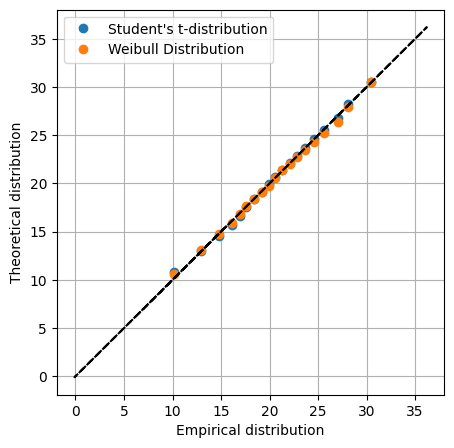

In [35]:
x = source_df['tmax'].dropna()

# Calculation of quantiles
percs = np.linspace(0, 100, 21)
qn_first = np.percentile(x, percs)
qn_1 = scipy.stats.t.ppf(percs / 100.0, *params_1)
qn_2 = scipy.stats.dweibull.ppf(percs / 100.0, *params_2)

# QQ-plot
plt.figure(figsize=(5, 5))
plt.plot(qn_first[1:], qn_1[1:], ls="", marker="o", label = 'Student\'s t-distribution')
plt.plot(qn_first[1:], qn_2[1:], ls="", marker="o", label = 'Weibull Distribution')
plt.plot(x, x, color="k", ls="--")
plt.xlabel('Empirical distribution')
plt.ylabel('Theoretical distribution')
plt.legend()
plt.grid(True)
plt.show()